In [1]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import random
import operator
import inspect
import scipy.stats as st

random.seed(4)
import matplotlib.pyplot as plt

In [2]:
def plot_hist(x, y, title, xlabel, ylabel, xtickslabel=None, size=None, rotation=0):
    
    if size:
        fig, ax = plt.subplots(1, 1, figsize=(size*6, 6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
    fig.tight_layout(pad=5)
    width = 0.5
    
    # x locations for codes
    ind = np.arange(1, 1+len(x))
    barlist0 = ax.bar(ind, y, width)
    # , color=["#069AF3","#FF00FF"]
    ax.set_xticks(ind)
    
    if xtickslabel:
        ax.set_xticklabels(xtickslabel, rotation=rotation)
    
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(title)
    ax.grid(alpha=0.4)

    plt.show()
    
    
def order_dict_by_value(dict_):
    """
    Order dictionary by the value contained
    """
    return {k: v for k, v in sorted(dict_.items(), key = lambda item: item[1], reverse=True)}

In [3]:
path = r"C:\PythonCode\JModelicaDocker\Agricore\WP2\tables\tablas"

In [4]:
# Loading table C in FADN format
table_C = pd.read_csv(os.path.join(path, "table_C.csv"))
table_A = pd.read_csv(os.path.join(path, "table_A.csv"))

In [5]:
table_A["A_TY_90_TF"].unique()

array([370, 614, 163, 380, 363, 166, 151], dtype=int64)

In [6]:
var="A_CL_141_C"
table_A[table_A[var]==34][var].count()

340

370, olivo  
614, field crops and permanent crops  
163, specialist field vegetables  
380, varios permanent crops combined
363, nuts
166, varios field crops combined
151, cereals different friom rice, oil crops and proteic crops

# 1. Data analysis
From the initial dataset, analyse which variables would be overlaped in case  all instances corresponding to one year and exploitation were located in the same instance. This will occur in case were co-exists more than one worker type for the same year and exploitation. For instance, if the exploitation A in the year 2021 has two workers and both have assigned the role of Holder/manager corresponding with code 10. 


Del total de explotacions cuantas tienen dueño y manager a la vez (10) cuantas tienen 10, 30 y para los que haya datos diferenciados por genero

In [7]:
table_C.head()

Ejercicio  Explotacion  Categoria  C_UR_40_P  C_UR_50_P  C_PR_50_P  \
0       2014        55284         10        NaN        NaN        NaN   
1       2014        55284         10        NaN        NaN        NaN   
2       2015        55284         10        NaN        NaN        NaN   
3       2015        55284         10        NaN        NaN        NaN   
4       2018        55290         10        NaN        NaN        NaN   

   C_UR_10_G  C_UR_20_G  C_UR_30_G  C_PR_70_G  ...  C_PR_50_G  C_PR_50_B  \
0        1.0        NaN        NaN        NaN  ...        NaN        NaN   
1        2.0        NaN        NaN        NaN  ...        NaN        NaN   
2        2.0        NaN        NaN        NaN  ...        NaN        NaN   
3        1.0        NaN        NaN        NaN  ...        NaN        NaN   
4        1.0        NaN        NaN        NaN  ...        NaN        NaN   

   C_PR_50_T  C_UR_20_P  C_UR_20_T  C_UR_20_Y2  C_UR_30_P  C_UR_30_Y2  \
0        NaN        NaN        NaN         NaN        NaN         NaN   
1        NaN        NaN        NaN         NaN        NaN         NaN   
2        NaN        NaN        NaN         NaN        NaN         NaN   
3        NaN        NaN        NaN         NaN        NaN         NaN   
4        NaN        NaN        NaN         NaN        NaN         NaN   

   C_PR_70_P  C_PR_70_Y2  
0        NaN         NaN  
1        NaN         NaN  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN  

[5 rows x 75 columns]

| Code |    Description    | Group code |   Code name    |
| :--: | :-----------------| :--------: | :------------- |
|  10  | Holder/manager    | UR         | Unpaid regular |
|  20  | Holder/not manager| UR         | Unpaid regular |
|  30  | Holder/manager    | UR         | Unpaid regular |
|  40  | Spouse of holder  | UR         | Unpaid regular |
|  50  | Other             | UR         | Unpaid regular |
|  50  | Other             | PR         | Paid regular   |
|  60  | Casual            | UC         | Unpaid casual  |
|  60  | Casual            | PC         | Paid casual    |
|  70  | Manager           | PR         | Paid regular   |


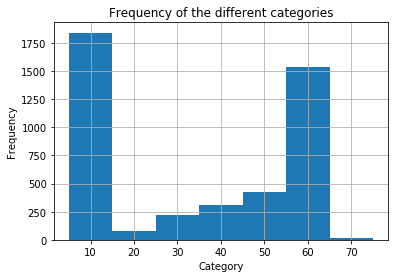

In [8]:
plt.hist(table_C.Categoria, bins=np.linspace(10, 80, 8)-5)

plt.title("Frequency of the different categories")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.grid()

plt.show()

# Codes repeated for the same instance (exp /year)

In [9]:
table_C["Categoria"].value_counts().to_dict()

{10: 1841, 60: 1532, 50: 425, 40: 306, 30: 224, 20: 76, 70: 17}

In [10]:
# All available exploitations
exploitations = sorted(table_C["Explotacion"].unique())

# Dictionary storing frequency of appearance of two equal codes in the same exploitation and year
repetitions = {10: 0, 20: 0, 30: 0, 40: 0, 50: 0, 60: 0, 70: 0}

# Dictionary storing the codes combinations in the dataset
combinations = {}

for ex in exploitations:
    
    # Select instances of the current exploitation
    df_e = table_C[table_C["Explotacion"] == ex]
    
    # Getting years available
    years = sorted(df_e["Ejercicio"].unique())
    
    # Loop all years
    for y in years:
        
        # Select year and exp instances
        df_e_y = df_e[df_e["Ejercicio"] == y]
        
        # Getting frequencies of codes
        frequencies = df_e_y["Categoria"].value_counts().to_dict()
        
        #
        for k in frequencies.keys():
            
            # Check code repetition
            if frequencies[k] > 1:
                repetitions[k] += 1
        
        # Checking code combination appearance
        if str(list(frequencies.keys())) in combinations.keys():
            combinations[str(list(frequencies.keys()))] += 1
        
        else:
            combinations[str(list(frequencies.keys()))] = 1
        

In [11]:
repetitions

{10: 119, 20: 0, 30: 0, 40: 0, 50: 1, 60: 52, 70: 0}

In [12]:
title = "Codes repeated and their\nfrequency of repetition"
xlabel = "Codes"
ylabel = "Frequency"
xtixkslabels = tuple(repetitions.keys())
plot_hist(repetitions.keys(), repetitions.values(), title, xlabel, ylabel, xtixkslabels)

From these results:
1. When 10 code is repeated, analyze which are the possible combinations between the frequencies given.  

2. When codes 50 or 60 are repeated, what characteristics do have the workers? Paid regular/unpaid regular (case 50) or Paid casual vs unpaid casual (case 60).

3. Codes 20, 30, 40, and 70 do not repeat in the same explitation.

In [13]:
# All available exploitations
exploitations = sorted(table_C["Explotacion"].unique())
n_couples = 0
n_same = 0

for ex in exploitations:
    
    # Select instances of the current exploitation
    df_e = table_C[table_C["Explotacion"] == ex]
    
    # Getting years available
    years = sorted(df_e["Ejercicio"].unique())
    
    # Loop all years
    for y in years:
        
        # Select year and exp instances
        df_e_y = df_e[df_e["Ejercicio"] == y]
        
        # Getting frequencies of codes
        frequencies = df_e_y["Categoria"].value_counts().to_dict()
        
        if 10 in frequencies.keys():
            
            if frequencies[10] > 1:
                
                # Two codes 10 with genders 1 and 2
                if len(df_e_y["C_UR_10_G"].value_counts().to_dict().keys()) > 1:
                    n_couples += 1
                # 
                if len(df_e_y["C_UR_10_G"].value_counts().to_dict().keys()) == 1:
                    n_same += 1
                    #print(df_e_y["C_UR_10_G"])
        
print(n_couples)
print(n_same)

31
88


There is not exploitation that contains two 10 code (Holder/manager) and the persons would have gender code 2

### 10 code analysis

In [14]:
# Dictionary storing the codes combinations in the dataset
combination_10 = {}

for ex in exploitations:
    
    # Select instances of the current exploitation
    df_e = table_C[table_C["Explotacion"] == ex]
    
    # Getting years available
    years = sorted(df_e["Ejercicio"].unique())
    
    # Loop all years
    for y in years:
        
        # Select year and exp instances
        df_e_y = df_e[df_e["Ejercicio"] == y]
        
        # Counting codes
        counts = df_e_y["Categoria"].value_counts().to_dict()
        
        # Index of farm type
        index = [k for k in counts.keys() for n in range(counts[k]) ]
        
        if 10 in index:
            index = str(sorted(index))
        
            if index in combination_10.keys():
                combination_10[index] += 1
            else:
                combination_10[index] = 1

combination_10 = order_dict_by_value(combination_10)

In [15]:
title = "Farm configuration when code 10 appears"
xlabel = "Codes configuration"
ylabel = "Frequency"
xtixkslabels = tuple(combination_10.keys())
plot_hist(sorted(combination_10.keys()), combination_10.values(), title, xlabel, ylabel, xtixkslabels, size=2, rotation=90)

Within each possible combination some codes may be repeated. 

## Holdigng configuration

In [16]:
# Counting the number of exploitations with certain labour configuration

# Dictionary to store results
distribution = {}

# Getting unique explouitations
exploitations = sorted(table_C["Explotacion"].unique())

for exp in exploitations:
    
    # Getting accountacy years
    exp_e = table_C[table_C["Explotacion"] == exp]
    years = sorted(exp_e["Ejercicio"].unique())
    
    for year in years:
        
        # Getting all categories
        cats = str(sorted(exp_e[exp_e["Ejercicio"]==year]["Categoria"].unique()))
        
        if cats in distribution.keys():
            distribution[cats] += 1
        
        else:
            distribution[cats] = 1
            
# Sorting dictionary by number of appearances
distribution = {k: v for k, v in sorted(distribution.items(), key = lambda item: item[1], reverse=True)}

In [17]:
# Dictionary storing the codes combinations in the dataset
distribution = {}

for ex in exploitations:
    
    # Select instances of the current exploitation
    df_e = table_C[table_C["Explotacion"] == ex]
    
    # Getting years available
    years = sorted(df_e["Ejercicio"].unique())
    
    # Loop all years
    for y in years:
        
        # Select year and exp instances
        df_e_y = df_e[df_e["Ejercicio"] == y]
        
        # Counting codes
        counts = df_e_y["Categoria"].value_counts().to_dict()
        
        # Index of farm type
        index = [k for k in counts.keys() for n in range(counts[k]) ]
        
        index = str(sorted(index))

        if index in distribution.keys():
            distribution[index] += 1
        else:
            distribution[index] = 1

distribution = order_dict_by_value(distribution)

In [18]:
distribution.keys()

dict_keys(['[10, 60]', '[10, 50, 60]', '[10, 40, 60]', '[10]', '[10, 30, 60]', '[10, 10, 60]', '[10, 50]', '[10, 40, 50, 60]', '[10, 40]', '[20, 30, 60]', '[10, 30, 50, 60]', '[10, 10, 10, 60]', '[10, 30]', '[10, 50, 60, 60]', '[10, 60, 60]', '[30, 60]', '[10, 20, 60]', '[10, 40, 50]', '[20, 30]', '[10, 30, 60, 60]', '[30, 50, 60]', '[10, 10, 10, 50, 60]', '[10, 10]', '[10, 60, 70]', '[10, 20]', '[20, 30, 40, 50, 60]', '[10, 50, 60, 60, 70]', '[10, 10, 50]', '[20, 30, 50, 60]', '[10, 30, 50]', '[30]', '[10, 10, 10]', '[20, 50, 70]', '[20, 70]', '[10, 10, 50, 60]', '[20, 30, 50]', '[10, 30, 40, 60]', '[10, 70]', '[10, 10, 10, 10, 10, 50]', '[10, 10, 10, 10, 30, 50, 60]', '[10, 20, 50, 60]', '[20, 60, 70]', '[10, 40, 50, 60, 60]', '[20, 30, 40, 50]', '[30, 50]', '[30, 60, 60]', '[10, 50, 50]', '[70]', '[10, 10, 10, 10, 10, 50, 60]', '[10, 10, 10, 10, 30, 50]', '[10, 10, 10, 50]', '[10, 50, 70]'])

Which of them have holder and manager at the same time?  
Keys that have holder and manager at the same time:
* n*[10] & n*[30]
* n*[10] & n*[20]
* n*[10] & n*[70]
* n*[20] & n*[30]
* n*[20] & n*[70]

In [19]:
list(distribution.keys()).index("[10, 60]")

0

In [20]:
manager_and_holder = []
color_list = ["b"]*len(distribution.keys())

for k in distribution.keys():
    k_t = ast.literal_eval(k)
    
    if 10 in k_t:
        if 20 in k_t or 30 in k_t or 70 in k_t:
            manager_and_holder.append(k)
            color_list.insert(list(distribution.keys()).index(k), "r")
            
    if 20 in k_t:
        if 30 in k_t or 70 in k_t:
            manager_and_holder.append(k)
            color_list.insert(list(distribution.keys()).index(k), "r")
            
    if k_t.count(10)>1 and k_t.count(30)==0 and k_t.count(70)==0:
        color_list.insert(list(distribution.keys()).index(k), "y")
        
manager_and_holder

['[10, 30, 60]',
 '[20, 30, 60]',
 '[10, 30, 50, 60]',
 '[10, 30]',
 '[10, 20, 60]',
 '[20, 30]',
 '[10, 30, 60, 60]',
 '[10, 60, 70]',
 '[10, 20]',
 '[20, 30, 40, 50, 60]',
 '[10, 50, 60, 60, 70]',
 '[20, 30, 50, 60]',
 '[10, 30, 50]',
 '[20, 50, 70]',
 '[20, 70]',
 '[20, 30, 50]',
 '[10, 30, 40, 60]',
 '[10, 70]',
 '[10, 10, 10, 10, 30, 50, 60]',
 '[10, 20, 50, 60]',
 '[20, 60, 70]',
 '[20, 30, 40, 50]',
 '[10, 10, 10, 10, 30, 50]',
 '[10, 50, 70]']

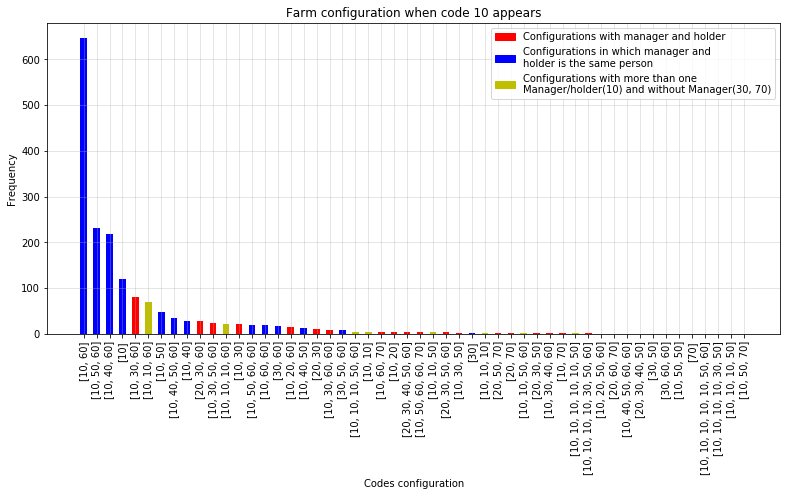

In [21]:
x = distribution.keys()
y = distribution.values()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

fig.tight_layout(pad=5)
width = 0.5

# x locations for codes
ind = np.arange(1, 1+len(x))
barlist0 = ax.bar(ind, y, width, color = color_list)

ax.set_xticks(ind)
ax.set_xticklabels(x, rotation=90)


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

red_patch = mpatches.Patch(color="red", label="Configurations with manager and holder")
blue_patch = mpatches.Patch(color="blue", label="Configurations in which manager and\nholder is the same person")
yellow_patch = mpatches.Patch(color="y", label="Configurations with more than one\nManager/holder(10) and without Manager(30, 70)")
plt.legend(handles=[red_patch, blue_patch, yellow_patch])

ax.set_title(title)
ax.grid(alpha=0.4)

plt.show()

Exploitations have been counted by classifying them according to the worker types code working on it. Some of them contain codes 50 and 60 so they also can be breakdown by paid or unpaid regular/casual.  
  
*Code 50, UR/PR*  
They have variables corresponding to:  
* **P**: Number of persons.
* **Y1**: Annual time worked(hours)
* **W1**: Number of annual work units(AWU).
* **Y2**: % of annual time worked (%).
* **W2**: % of AWU (%).

*Code 60 UC/PC*  
They have variables corresponding to:  
* **Y1**: Annual time worked(hours)
* **Y2**: % of annual time worked (%).
 
An analysis of the frequency of paid/unpaid will be done for codes 50 and 60.

In [22]:
# Compossing variables available for each code group (50/60)

"C_UR/PR_50_{P/Y1/W1/Y2/W2}"
# Type 50 variables
type_50 = []

for reg in ["UR", "PR"]:
    
    for g in ["P", "Y1", "W1", "Y2", "W2"]:
        
        type_50.append("C_{}_50_{}".format(reg, g))

"C_UC/PC_60_{Y1/Y2}"
# Type 60 variables
type_60 = []

for reg in ["UC", "PC"]:
    
    for g in ["Y1", "Y2"]:
        
        type_60.append("C_{}_60_{}".format(reg, g))

## Variable analysis, 50 and 60 groups

In [23]:
# Instances containing code 50
code = 50
presence_50 = table_C[table_C["Categoria"]==code][[col for col in table_C[table_C["Categoria"]==code].columns if col in type_50]]


In [24]:
# Instances containing code 60
code = 60
presence_60 = table_C[table_C["Categoria"]==code][[col for col in table_C[table_C["Categoria"]==code].columns if col in type_60]]

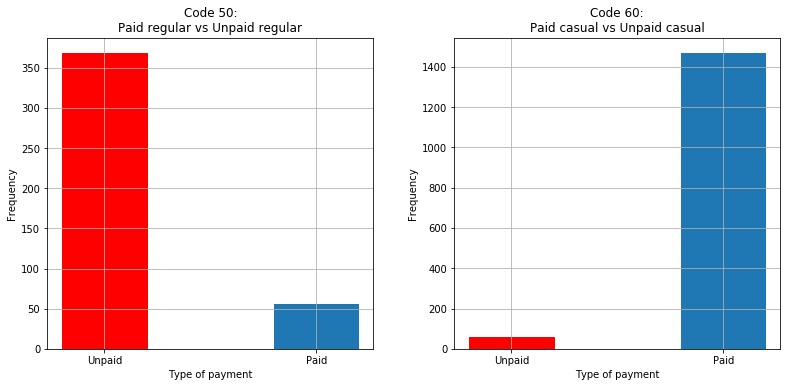

In [25]:
cat_60_frequency = {"Unpaid": presence_60["C_UC_60_Y1"].count(),
                   "Paid": presence_60["C_PC_60_Y1"].count()}

cat_50_frequency = {"Unpaid": presence_50["C_UR_50_Y1"].count(),
                    "Paid": presence_50["C_PR_50_Y1"].count()}

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout(pad=5)
width = 0.4
barlist0 = axs[0].bar(cat_50_frequency.keys(), cat_50_frequency.values(), width=width)

barlist0[0].set_color("r")

axs[0].set_title("Code 50:\nPaid regular vs Unpaid regular")
axs[0].set_xlabel("Type of payment")
axs[0].set_ylabel("Frequency")
axs[0].grid()

barlist1 = axs[1].bar(cat_60_frequency.keys(), cat_60_frequency.values(), width=width)
barlist1[0].set_color("r")

axs[1].set_title("Code 60:\nPaid casual vs Unpaid casual")
axs[1].set_xlabel("Type of payment")
axs[1].set_ylabel("Frequency")
axs[1].grid()

plt.show()

In [26]:
print(cat_50_frequency)
print(cat_60_frequency)

{'Unpaid': 369, 'Paid': 56}
{'Unpaid': 61, 'Paid': 1471}


**Code 50**
86.82% of instances in which apper code 50 correspond to *unpaid regular*.  
Unpaid regular for code 50 

Unpaid labour or labour which receives less remuneration (in cash or in  kind) than the amount normally paid for the services rendered (such payment should not appear in farm costs) and which during the accounting year participated (outside normal holidays) for at least a 
whole day of each week. 
A person employed regularly but who, for special reasons, has been engaged on the farm only for a limited period in the accounting year is nevertheless entered (for the number of hours actually worked) as regular labour. 
The following cases or similar ones may arise: 
* special production conditions on the farm for which labour is not required throughout the year: e.g. olive or vine holdings, and farms specialising in the seasonal fattening of animals or in the production of fruit and vegetables in the open; 
* absence from work other than for normal holidays, e.g. military  service, illness, accident, maternity, extended leave, etc.; 
* joining or leaving the holding; 
* total cessation of work on the holding due to accidental causes (flood, fire, etc.). 

**Code 60**  
96.01% of instances in which appear code 60 correspond to *paid casual*.  
Paid casual for code 60 is labour paid (in cash and/or in kind) on the normal scale for services rendered and which during the accounting year (excluding normal holidays) worked for at least one whole day per week for the holding. 

The other case is *unpaid casual* that  corresponds to unpaid labour or labour which receives less remuneration (in cash or in kind) than the amount normally paid for the services rendered (such payment should not appear in farm costs) and which during the accounting year participated (outside normal holidays) for less than a whole day of each week and there were no special reasons (as explained in the same column at the beginning of this Table) that she/he, has been engaged on the farm only for a limited period in the accounting year.
  
In both cases, values corresponding to *Y2* are zeros for the whole series so  the work made by these workers does not count in the total work percentage.

# Number of workers per exploitation

In [27]:
# Number of workers per exploitations and year

n_workers = {}

for year in sorted(table_C["Ejercicio"].unique()):
    
    for exp in sorted(table_C[table_C["Ejercicio"]==year]["Explotacion"].unique()):
        
        n = len(table_C[(table_C["Ejercicio"]==year)&(table_C["Explotacion"]==exp)])
        
        if n > 0:
            
            if n in n_workers.keys():
                n_workers[n] += 1
            
            else:
                n_workers[n] = 1
        

In [28]:
n_workers

{2: 786, 1: 125, 3: 709, 4: 122, 5: 14, 6: 3, 7: 3}

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
#fig.tight_layout(pad=5)

axs.bar(n_workers.keys(), n_workers.values())

axs.set_title("Number of workers frequency")
axs.set_xlabel("Number of workers")
axs.set_ylabel("Frequency")
axs.grid()

plt.show()

In [30]:
# Farm configuration by number of workers
dist_by_n_workers = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}

for k in distribution.keys():

    dist_by_n_workers[len(ast.literal_eval(k))].append([ast.literal_eval(k), distribution[k]])

In [31]:
dist_by_n_workers

{1: [[[10], 121], [[30], 3], [[70], 1]],
 2: [[[10, 60], 647],
  [[10, 50], 48],
  [[10, 40], 29],
  [[10, 30], 21],
  [[30, 60], 17],
  [[20, 30], 11],
  [[10, 10], 4],
  [[10, 20], 4],
  [[20, 70], 2],
  [[10, 70], 2],
  [[30, 50], 1]],
 3: [[[10, 50, 60], 231],
  [[10, 40, 60], 219],
  [[10, 30, 60], 81],
  [[10, 10, 60], 71],
  [[20, 30, 60], 29],
  [[10, 60, 60], 19],
  [[10, 20, 60], 15],
  [[10, 40, 50], 14],
  [[30, 50, 60], 8],
  [[10, 60, 70], 4],
  [[10, 10, 50], 4],
  [[10, 30, 50], 3],
  [[10, 10, 10], 3],
  [[20, 50, 70], 2],
  [[20, 30, 50], 2],
  [[20, 60, 70], 1],
  [[30, 60, 60], 1],
  [[10, 50, 50], 1],
  [[10, 50, 70], 1]],
 4: [[[10, 40, 50, 60], 36],
  [[10, 30, 50, 60], 25],
  [[10, 10, 10, 60], 23],
  [[10, 50, 60, 60], 19],
  [[10, 30, 60, 60], 8],
  [[20, 30, 50, 60], 4],
  [[10, 10, 50, 60], 2],
  [[10, 30, 40, 60], 2],
  [[10, 20, 50, 60], 1],
  [[20, 30, 40, 50], 1],
  [[10, 10, 10, 50], 1]],
 5: [[[10, 10, 10, 50, 60], 5],
  [[20, 30, 40, 50, 60], 4],
  [[

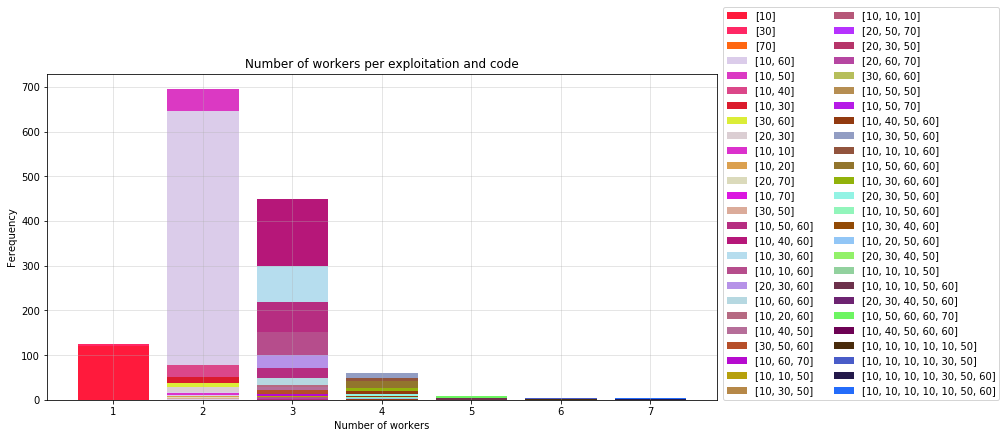

In [32]:
# Plot generation
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# x locations for codes
ind = np.arange(len(dist_by_n_workers.keys())) 
width = 0.5

# Legend list in order of drawing
legend = []
r = 1
g = 0
b = 1
# Loop all number of workers
for k in dist_by_n_workers.keys():
    
    # Keeping red color for the same number of workers group
    #r = random.random()
    
    for p in range(len(dist_by_n_workers[k])):
        
        # Varying  blue and green for the group type
        b = random.random()
        g = random.random()
        
        # Color composition
        color = (r, g, b)
        
        # Plot bars
        if p == 0:
            p1 = ax.bar(k, dist_by_n_workers[k][p][1], color=color, label=dist_by_n_workers[k][p][0])
        else:
            p1 = ax.bar(k, dist_by_n_workers[k][p][1], bottom=dist_by_n_workers[k][p-1][1], color=color, label=dist_by_n_workers[k][p][0])
    
    r -= 1/7
    
ax.set_ylabel("Ferequency")
ax.set_xlabel("Number of workers")

ax.set_title("Number of workers per exploitation and code")

ax.legend(loc=(1.01, 0), ncol=2)

ax.grid(alpha=0.4)
plt.show()


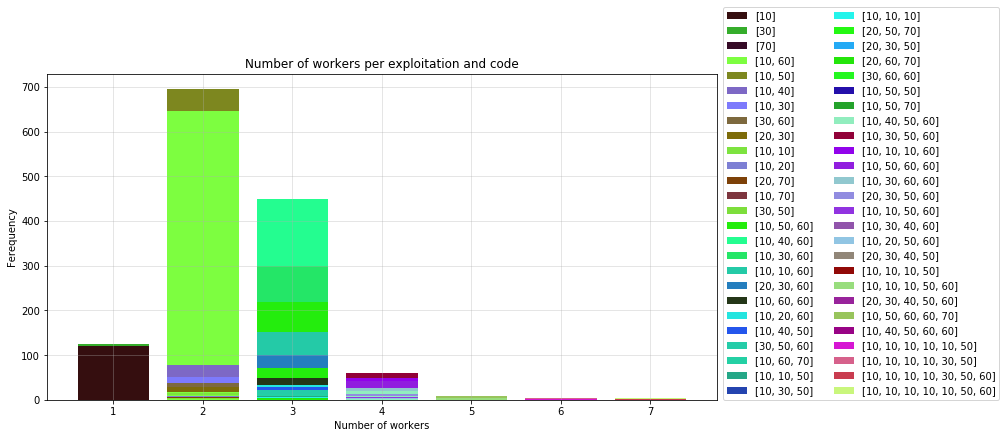

In [33]:
# Plot generation
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# x locations for codes
ind = np.arange(len(dist_by_n_workers.keys())) 
width = 0.5

# Legend list in order of drawing
legend = []

# Loop all number of workers
for k in dist_by_n_workers.keys():
    
    # Keeping red color for the same number of workers group
    r = random.random()
    
    for p in range(len(dist_by_n_workers[k])):
        
        # Varying  blue and green for the group type
        b = random.random()
        g = random.random()
        
        # Color composition
        color = (r, g, b)
        
        # Plot bars
        if p == 0:
            p1 = ax.bar(k, dist_by_n_workers[k][p][1], color=color, label=dist_by_n_workers[k][p][0])
        else:
            p1 = ax.bar(k, dist_by_n_workers[k][p][1], bottom=dist_by_n_workers[k][p-1][1], color=color, label=dist_by_n_workers[k][p][0])

ax.set_ylabel("Ferequency")
ax.set_xlabel("Number of workers")

ax.set_title("Number of workers per exploitation and code")

ax.legend(loc=(1.01, 0), ncol=2)

ax.grid(alpha=0.4)
plt.show()


In [34]:
def plot_gender_training(gender, training, code):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=5)
    width = 0.5
    # AX0

    # x locations for codes
    ind = np.arange(1, 1+len(gender.keys()))
    barlist0 = ax[0].bar(ind, gender.values(), width, color=["#069AF3","#FF00FF"])

    ax[0].set_xticks(ind)
    ax[0].set_xticklabels(("Male", "Female"))

    ax[0].set_ylabel("Ferequency")
    ax[0].set_xlabel("Category")
    ax[0].set_title("Genders in category {}".format(code))
    ax[0].grid(alpha=0.4)

    ind = np.arange(1, 1+len(training.keys()))

    barlist1 = ax[1].bar(ind, training.values(), width, color=["r", "g", "b"], alpha=0.9)

    ax[1].set_ylabel("Ferequency")
    ax[1].set_xlabel("Category")
    ax[1].set_title("Training in category {}".format(code))
    ax[1].grid(alpha=0.4)

    ax[1].set_xticks(ind)
    ax[1].set_xticklabels(("1", "2", "3"))
    #plt.legend((p1[0], p2[0]), ("Male", "Female"))

    plt.show()

# Code 10 Gender and training classification

In [35]:
coded_10 = table_C[table_C["Categoria"]==10]

# Coded 10 by gender
gender_10 = coded_10["C_UR_10_G"].value_counts().to_dict()

training_10 = coded_10["C_UR_10_T"].value_counts().to_dict()

In [36]:
plot_gender_training(gender_10, training_10, "10")

# Code 20 Gender and training classification

In [37]:
coded_20 = table_C[table_C["Categoria"]==20]

# Coded 10 by gender
gender_20 = coded_20["C_UR_20_G"].value_counts().to_dict()

training_20 = coded_20["C_UR_20_T"].value_counts().to_dict()

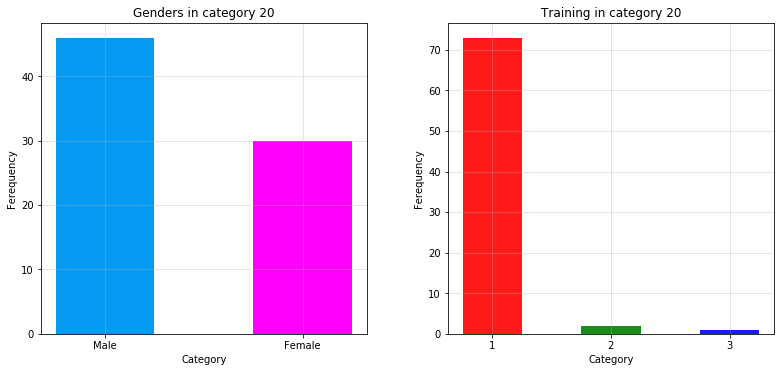

In [38]:
plot_gender_training(gender_20, training_20, "20")

# Code 30 Gender and training classification

In [39]:
coded_30 = table_C[table_C["Categoria"]==30]

# Coded 30 by gender
gender_30 = coded_30["C_UR_30_G"].value_counts().to_dict()

training_30 = coded_30["C_UR_30_T"].value_counts().to_dict()

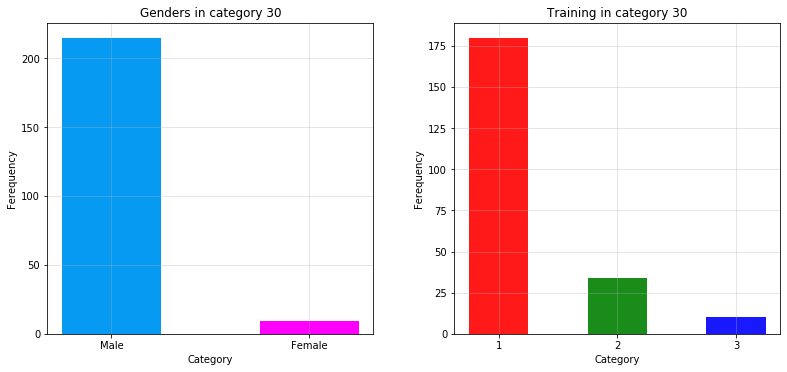

In [40]:
plot_gender_training(gender_30, training_30, "30")

# Code 70 Gender and training classification

In [41]:
coded_70 = table_C[table_C["Categoria"]==70]

# Coded 70 by gender
gender_70 = coded_70["C_PR_70_G"].value_counts().to_dict()

training_70 = coded_70["C_PR_70_T"].value_counts().to_dict()

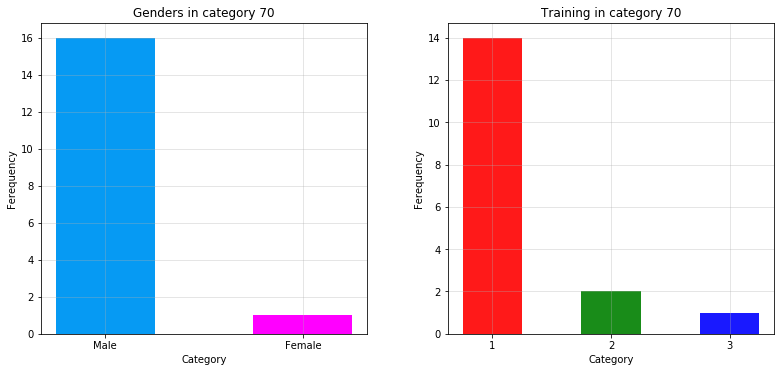

In [42]:
plot_gender_training(gender_70, training_70, "70")

In [43]:
males = {}
females = {}

for c in [10, 20, 30, 70]:
    
    # Instances with the code c
    df_code = table_C[table_C["Categoria"]==c]
    
    if c in [10, 20, 30]:
        
        males[c] = df_code[df_code["C_UR_{}_G".format(c)]==1].shape[0]
        females[c] = df_code[df_code["C_UR_{}_G".format(c)]==2].shape[0]
    else:
        males[c] = df_code[df_code["C_PR_{}_G".format(c)]==1].shape[0]
        females[c] = df_code[df_code["C_PR_{}_G".format(c)]==2].shape[0]

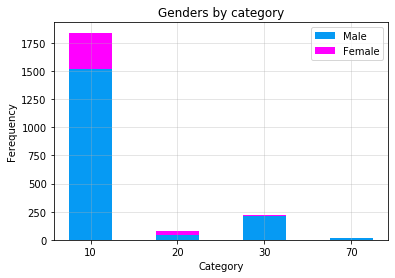

In [44]:
# x locations for codes
ind = np.arange(len(males.keys())) 
width = 0.5

p1 = plt.bar(ind, males.values(), width, color="#069AF3")
#p2 = plt.bar(ind, females.values(), width,
#             bottom=list(males.values()), color="#d62728")

p2 = plt.bar(ind, females.values(), width,
             bottom=list(males.values()), color="#FF00FF")

plt.ylabel("Ferequency")
plt.xlabel("Category")

plt.title("Genders by category")
plt.xticks(ind, ("10", "20", "30", "70"))
plt.legend((p1[0], p2[0]), ("Male", "Female"))

plt.grid(alpha=0.4)
plt.show()

In [45]:
pd.DataFrame(list(zip(males.values(), females.values())), columns=["male", "female"], index=[10, 20, 30, 70])

male  female
10  1515     326
20    46      30
30   215       9
70    16       1

## Distributions for categorical variables

| Name | Range | $P(k) = P(X=k)\space for\space k \in range$ | mean |      variance    |
| :--: | :---: | :-----------------------------------------: | :--: | :-------------: |
| Uniform | {a, a+1, b} | $\frac{1}{b-a+1}$ | $\frac{a+b}{2}$ | $\frac{{(b-a+1)}^2-1}{12}$ | 
| Bernoulli(p) | {0, 1} | $P(1)=p;P(0)=1-p$ | $p$ | $p(1-p)$ | 
| binomial(n, p) | {0, 1, ..., n} | $P(1)=p;P(0)=1-p$ | $p$ | $p(1-p)$ | 


* Uniform

* Binomial distribution
* Poisson distribution
* Hypergeometric distribution


# PDF estimation

In [46]:
def select_distribution(family="realall", verbose=True):
    """
    This function selects a subset of available distributions in scipy.stats.
    """
    
    # Obtaining distributions
    distributions = [getattr(st, d) for d in dir(st) \
                    if isinstance(getattr(st, d), (st.rv_continuous, st.rv_discrete))]
    
    # Excluded distributions
    #excluded = ["levy_stable", "vonmisses"]
    excluded = []
    distributions = [dist for dist in distributions if dist not in excluded]
    
    # Defining domains
    domains = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discrete': [None, None],
    }
    
    distribution = []
    type_ = []
    domain_low = []
    domain_high = []
    
    for dist in distributions:
        distribution.append(dist.name)
        type_.append(np.where(isinstance(dist, st.rv_continuous), "continuous", "discrete"))
        domain_low.append(dist.a)
        domain_high.append(dist.b)
        
    info_distributions = pd.DataFrame({
        "distribution": distribution,
        "type": type_,
        "domain_low": domain_low,
        "domain_high": domain_high
    })
    
    info_distributions = info_distributions \
                          .sort_values(by=['domain_low', 'domain_high'])\
                          .reset_index(drop=True)
    
    if family in ['realall', 'realline', 'realplus', 'real0to1']:
        
        info_distributions = info_distributions[info_distributions['type']=='continuous']
        condition = (info_distributions['domain_low'] == domains[family][0]) & \
                    (info_distributions['domain_high'] == domains[family][1]) 
        info_distributions = info_distributions[condition].reset_index(drop=True)
        
    if family in ['discrete']:
        info_distributions = info_distributions[info_distributions['type']=='discrete']
        
    selection = [dist for dist in distributions \
                 if dist.name in info_distributions['distribution'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("            Selected distributions                 ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distributions)
    
    return selection


def compare_distributions(X, family="realall", order="aic", verbose=True):
    """
    This functions selects and adjust a subset of available distributions in scipy.stats. 
    For each distribution, Log likelohood, AIC and BIC are computed.
    """
    
    # Getting a list of all available distributions
    distributions = select_distribution(family=family, verbose=verbose)
    
    bins=200
    # Get histogram of original data
    y, x = np.histogram(X, bins=bins, density=True)
    
    # Bins converssion
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Declaration of some lists
    distribution_ = []
    
    n_parameters_ = []
    parameters_ = []
    error_ = []
    
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    # Fitting data to all distributions
    for i, distribution in enumerate(distributions):
        
        # Fitting message
        print(f"{i+1}/{len(distributions)} Adjusting distribution: {distribution.name}")
        
        # Excluded distributions
        if distribution.name not in ["levy_stable"]:
            
            ##################################            
            # Fitting data
            parameters = distribution.fit(X)

            # Getting parameter names
            parameters_names = [p for p in inspect.signature(distribution._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]

            # Building a dictionary with parameter names and values
            params = dict(zip(parameters_names, parameters))
            
            # Generate probability density function
            pdf = distribution.pdf(x, *parameters)
            sse = np.sum(np.power(y - pdf, 2))
            
            # Computing squared error
            error = np.sum((y - pdf)**2)
            
            # Comparing error
            if best_sse > error > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse

            distribution_.append(distribution.name)

            error_.append(error)
            n_parameters_.append(len(parameters))
            parameters_.append(params)

    results = pd.DataFrame({
                'distribution': distribution_,
                'error': error_,
                'n_parameters': n_parameters_,
                'parameters': parameters_,

                 })

    ##'log_likelihood': log_likelihood_,
    ##'aic': aic_,
    ##'bic': bic_,

    results = results.sort_values(by="error").reset_index(drop=True)

    #except Exception as e:
    #    print(f"Error trying to adjust the distribution {distribution.name}")
    #    print(e)
    #    print("")

    return results


def plot_distribution(x, distribution_name, ax=None):
    """
    This functions overlaps the density curve of a fistribution with the data histogram.
    
    Parameters
    ----------
    x: array
        data with which adjust the distribution
        
    distribution_name : str
        name of one of available distributions in 'scipy.stats'
        
    Returns
    -------
    results: matplotlib.ax
        created graph
        
    Raises
    ------
        
    Notes
    -----
    """

    distribution = getattr(st, distribution_name)

    parameters = distribution.fit(data=x)

    parameter_names = [p for p in inspect.signature(distribution._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parameters_dict = dict(zip(parameter_names, parameters))

    log_likelihood = distribution.logpdf(x, *parameters).sum()

    aic = -2 * log_likelihood + 2 * len(parameters)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parameters)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribution.pdf(x_hat, *parameters)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribution.name)
    ax.hist(x=x, density=True, bins=50, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.0), '|k', markeredgewidth=1)
    ax.set_title('Fitted distribution')
    ax.set_xlabel('x')
    ax.set_ylabel('Probability density')
    ax.legend();

    print('---------------------')
    print('Fitting results')
    print('---------------------')
    print(f"Distribution:   {distribution.name}")
    print(f"Domain:        {[distribution.a, distribution.b]}")
    print(f"Parameters:     {parameters_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax


def plot_multiple_distributions(x, distribution_names, ax=None):
    """
    This functions overlasps the density curves of several distributions with the data 
    histogram.
    
    Parameters
    ----------
    
    x: array
        data with which to adjust the distribution
        
    distribution_names: list
        list with available distribution names in "scipy.stats"
    
    Returns
    -------
    results: matplotlib.ax
        creadted graph
    
    Raises
    ------
    
    Notes
    -----
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    #ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Fitted distribution')
    ax.set_xlabel('x')
    ax.set_ylabel('Probability density')
    
    for name in distribution_names:
        
        distribution = getattr(stats, name)

        parameters = distribution.fit(data=x)

        parameter_names = [p for p in inspect.signature(distribution._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parameters_dict = dict(zip(parameter_names, parameters))

        log_likelihood = distribution.logpdf(x, *parameters).sum()

        aic = -2 * log_likelihood + 2 * len(parameters)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parameters)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribution.pdf(x_hat, *parameters)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribution.name)
    
    ax.legend();
    
    return ax

In [47]:
var = table_C[table_C["Categoria"]==10]["C_UR_10_G"].to_numpy().reshape(-1, 1)

In [48]:
#results = compare_distributions(var)

In [49]:
#results.iloc[0].parameters

In [50]:
"""# Plotting single distribution
fig, ax = plt.subplots(figsize=(8,5))

plot_distribution(
    x=var,
    distribution_name=results['distribution'][3],
    ax=ax
);
"""

"# Plotting single distribution\nfig, ax = plt.subplots(figsize=(8,5))\n\nplot_distribution(\n    x=var,\n    distribution_name=results['distribution'][3],\n    ax=ax\n);\n"

In [51]:
n, p = 3, 0.9
x = st.binom.rvs(n, p, size=1000)

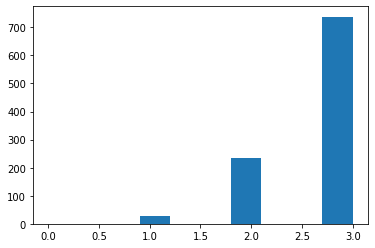

In [52]:
plt.hist(x, bins=10)
plt.show()

# Training level per category
The agricultural training should be given only for the manager(s) (categories 10, 30 and 70 from groups ‘unpaid regular labour’ UR or ‘paid regular labour’ PR). The agricultural training is indicated by a ode number
 
* 1: only practical agricultural experience
* 2: basic agricultural training
* 3: full agricultural training.

In [53]:
training = {10: {1: {1: 0, 2: 0, 3: 0},
                 2: {1: 0, 2: 0, 3: 0}},
            30: {1: {1: 0, 2: 0, 3: 0},
                 2: {1: 0, 2: 0, 3: 0}},
            70: {1: {1: 0, 2: 0, 3: 0},
                 2: {1: 0, 2: 0, 3: 0}}}

for c in training.keys():
    
    # Instances with the code c
    df_code = table_C[table_C["Categoria"]==c]
    
    for gen in [1, 2]:

        for t in [1, 2, 3]:

            if c in [10, 30]:

                training[c][gen][t] = df_code[(df_code["C_UR_{}_G".format(c)]==gen)&(df_code["C_UR_{}_T".format(c)]==t)].shape[0]
            
            else:
                training[c][gen][t] = df_code[(df_code["C_PR_{}_G".format(c)]==gen)&(df_code["C_PR_{}_T".format(c)]==t)].shape[0]
            

In [54]:
training

{10: {1: {1: 1256, 2: 199, 3: 60}, 2: {1: 278, 2: 32, 3: 16}},
 30: {1: {1: 171, 2: 34, 3: 10}, 2: {1: 9, 2: 0, 3: 0}},
 70: {1: {1: 14, 2: 0, 3: 2}, 2: {1: 0, 2: 1, 3: 0}}}

In [55]:
print(training[10][2][1]/training[10][1][1])
print(training[10][2][2]/training[10][1][2])
print(training[10][2][3]/training[10][1][3])

0.2213375796178344
0.16080402010050251
0.26666666666666666


In [56]:
def _plot_training(training, cat):
    """
    Plot histogram of training level and gender by category.
    """
    # x locations for codes
    ind = np.arange(3) 
    width = 0.5

    p1 = plt.bar(ind, training[cat][1].values(), width, color="#069AF3")

    p2 = plt.bar(ind, training[cat][2].values(), width,
                 bottom=list(training[cat][1].values()), color="#FF00FF")

    plt.ylabel("Ferequency")
    plt.xlabel("Training level")

    plt.title("Training level. Cat {}".format(cat))
    plt.xticks(ind, ("1", "2", "3"))
    plt.legend((p1[0], p2[0]), ("Male", "Female"))

    plt.grid(alpha=0.4)
    plt.show()


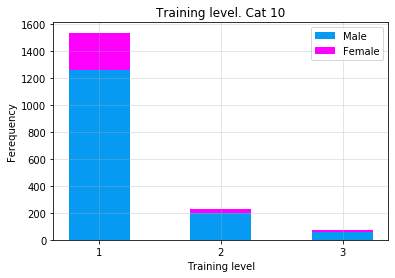

In [57]:
_plot_training(training, 10)

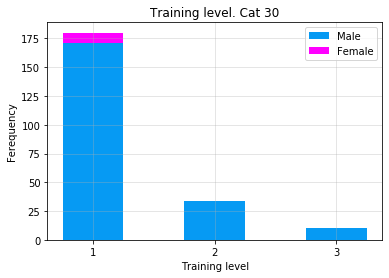

In [58]:
_plot_training(training, 30)

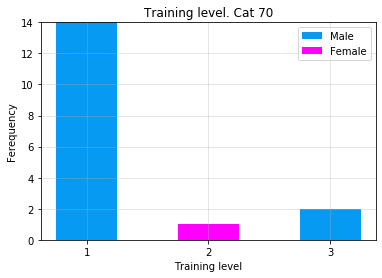

In [59]:
_plot_training(training, 70)

## Ages

In [60]:
def plot_ages(table_C, birth, title=None, bins=None):
    
    
    ages = table_C[table_C[birth].notnull()]["Ejercicio"].sub(table_C[table_C[birth].notnull()][birth], axis=0)
    if title:
        plt.title(title)
    plt.hist(ages, bins=bins)
    plt.grid(alpha=0.5)
    plt.xlabel("Ages")
    plt.ylabel("Frequency")
    
    plt.show()    
    

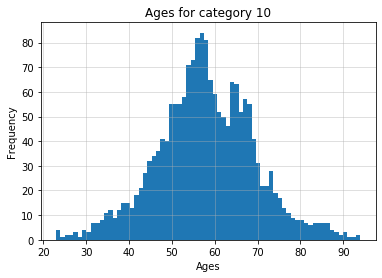

In [61]:
plot_ages(table_C, "C_UR_10_B", "Ages for category 10", bins=70)

In [62]:
plot_ages(table_C, "C_UR_20_B", "Ages for category 20", bins=15)

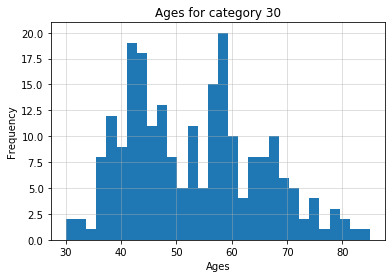

In [63]:
plot_ages(table_C, "C_UR_30_B", "Ages for category 30", bins=30)

In [64]:
plot_ages(table_C, "C_PR_70_B", "Ages for category 70")

## Gender vs age

In [65]:
def method(man, wom):
    
    keys_ = []
    
    keys_ = [k for k in man.keys()]
    
    for k in wom.keys():
        
        if k not in keys_:
            keys_.append(k)
    man_ = {}
    wom_ = {}

    for k in keys_:
        if k in man.keys():
            man_[k] = man[k]
        else:
            man_[k] = 0
        if k in wom.keys():
            wom_[k] = wom[k]
        else:
            wom_[k] = 0
    return man_, wom_


def _plot_training(man, wom, cat):
    """
    Plot histogram of mans and womens by category.
    """
    
    man, wom = method(man, wom)
    
    width = 0.5
    
    p1 = plt.bar(man.keys(), man.values(), width, color="#069AF3")

    p2 = plt.bar(wom.keys(), wom.values(), width, 
                 bottom=list(man.values()), color="#FF00FF")

    plt.ylabel("Ferequency")
    plt.xlabel("Age")

    plt.title("Age vs gender. Cat {}".format(cat))
    #plt.xticks(ind, ("1", "2", "3"))
    #plt.legend((p1[0], p2[0]), ("Male", "Female"))

    plt.grid(alpha=0.4)
    plt.show()


def _plot_training2(man, wom, cat):
    """
    Plot histogram of mans and womens by category.
    """
    
    width = 0.5
    
    p1 = plt.bar(man.keys(), man.values(), width, color="#069AF3", alpha=0.5)

    p2 = plt.bar(wom.keys(), wom.values(), width, color="#FF00FF", alpha=0.5)

    plt.ylabel("Ferequency")
    plt.xlabel("Age")

    plt.title("Age vs gender. Cat {}".format(cat))
    #plt.xticks(ind, ("1", "2", "3"))
    #plt.legend((p1[0], p2[0]), ("Male", "Female"))

    plt.grid(alpha=0.4)
    plt.show()

    
def _plot_training2(man, wom, cat, year, mean_m, std_m, mean_w, std_w):
    """
    Plot histogram of mans and womens by category.
    """
    
    width = 0.5
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Age vs gender. Cat {}, year {}".format(cat, year))

    # ax 0
    axs[0].bar(man.keys(), man.values(), width=width, color="#069AF3")
    axs[0].grid(alpha=0.4)
    axs[0].set_ylabel("Ferequency")
    axs[0].set_xlabel("Age")
    axs[0].set_xlim(20, 100)
    
    # Number of male workers
    n = pd.DataFrame(man.values()).sum().item()
    
    patch = mpatches.Patch(color="#069AF3", label="Gender: male\nYear: {}\nMean: {}\nSt dev: {}\nTotal: {}".format(year, round(mean_m, 2), round(std_m, 2), n))
    axs[0].legend(handles=[patch])

    # ax 1
    if len(wom.keys()) > 0:
        axs[1].bar(wom.keys(), wom.values(), width=width, color="#FF00FF")
        
        # Number of female workers
        n = pd.DataFrame(wom.values()).sum().item()
    else:
        axs[1].bar([20, 80], [0, 0], width=width, color="#FF00FF")
        n=0
    axs[1].grid(alpha=0.4)
    axs[1].set_ylabel("Ferequency")
    axs[1].set_xlabel("Age")

    patch = mpatches.Patch(color="#FF00FF", label="Gender: female\nYear: {}\nMean: {}\nSt dev: {}\nTotal: {}".format(year, round(mean_w, 2), round(std_w, 2), n))
    axs[1].legend(handles=[patch])
    axs[1].set_xlim(20, 100)
    plt.show()

    #plt.xticks(ind, ("1", "2", "3"))
    #plt.legend((p1[0], p2[0]), ("Male", "Female"))

    

In [66]:
years = sorted(table_C["Ejercicio"].unique())
years

[2014, 2015, 2016, 2017, 2018]

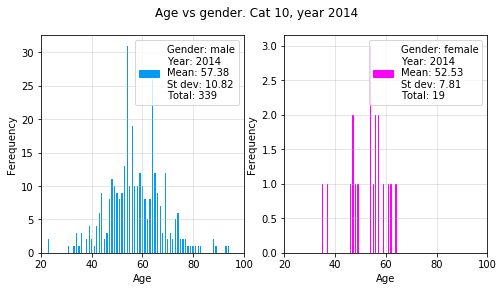

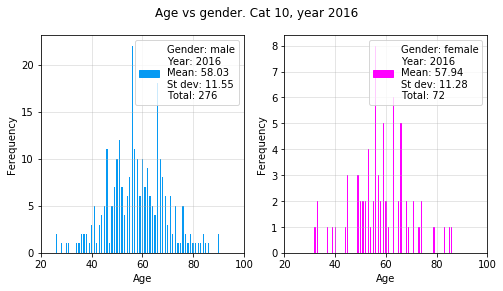

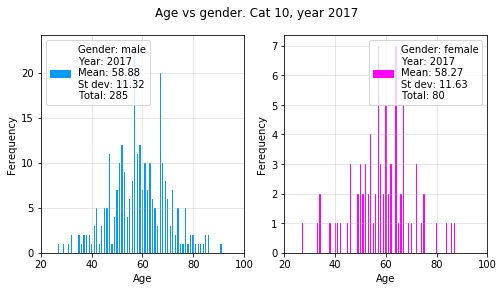

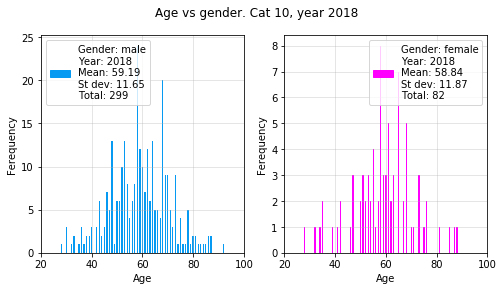

In [67]:
# Category 10
cat = 10
exe = 2017
var_g = "C_UR_10_G"
var_b = "C_UR_10_B"

for exe in years:
    gen = 1
    age_10_man = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_10_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_10_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    gen = 2
    age_10_wom = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_10_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_10_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    #_plot_training(age_10_man, age_10_wom, cat)
    #_plot_training2(age_10_man, age_10_wom, cat)
    #plot_gender_training(age_10_man, age_10_wom, cat)
    _plot_training2(age_10_man, age_10_wom, cat, exe, mean_10_m, std_10_m, mean_10_w, std_10_w)

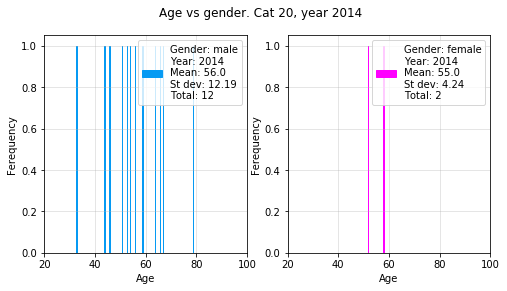

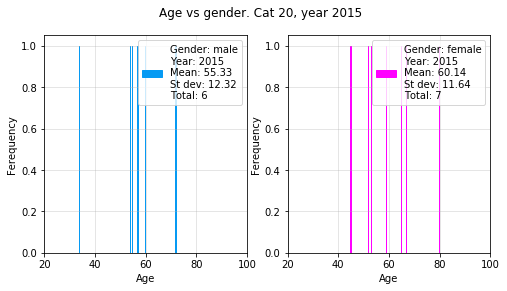

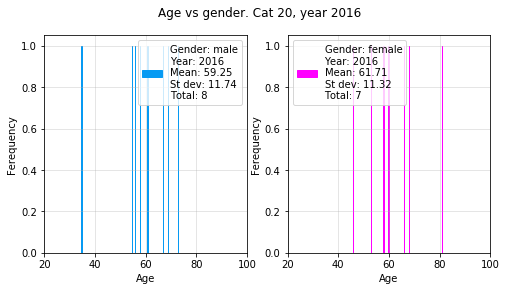

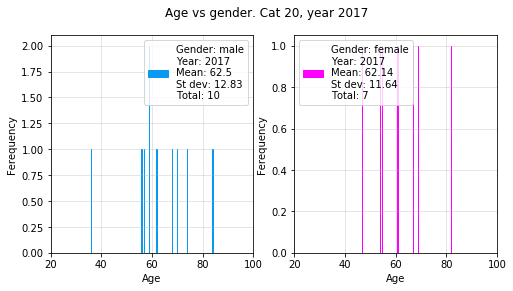

In [68]:
# Category 20
cat = 20

var_g = "C_UR_20_G"
var_b = "C_UR_20_B"

for exe in years:
    gen = 1
    age_20_man = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_20_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_20_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    gen = 2
    age_20_wom = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_20_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_20_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    _plot_training2(age_20_man, age_20_wom, cat, exe, mean_20_m, std_20_m, mean_20_w, std_20_w)

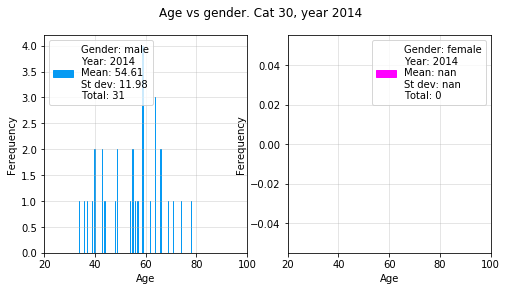

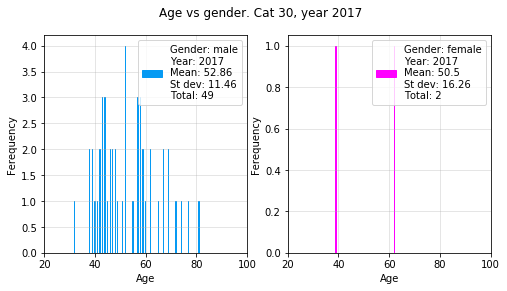

In [69]:
# Category 30
cat = 30

var_g = "C_UR_30_G"
var_b = "C_UR_30_B"

for exe in years:
    gen = 1
    age_30_man = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_30_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_30_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    gen = 2
    age_30_wom = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_30_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_30_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    _plot_training2(age_30_man, age_30_wom, cat, exe, mean_30_m, std_30_m, mean_30_w, std_30_w)

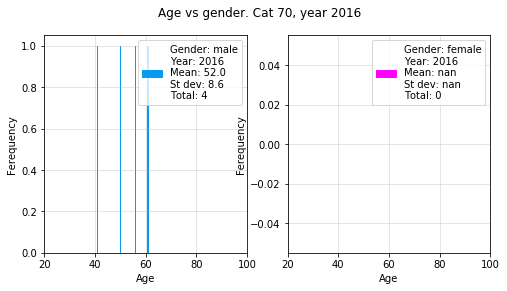

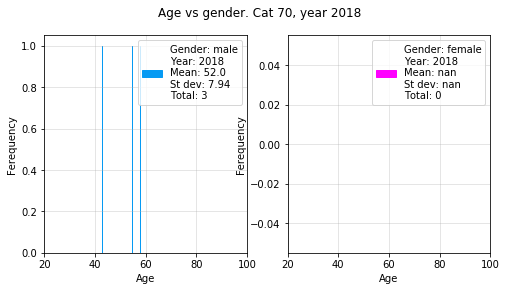

In [70]:
# Category 70
cat = 70

var_g = "C_PR_70_G"
var_b = "C_PR_70_B"

for exe in years:
    gen = 1
    age_70_man = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_70_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_70_m = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    gen = 2
    age_70_wom = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).value_counts().to_dict()
    mean_70_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).mean()
    std_70_w = table_C[(table_C["Ejercicio"]==exe)&(table_C["Categoria"]==cat)&(table_C[var_g]==gen)]["Ejercicio"].sub(table_C[(table_C["Categoria"]==cat)&(table_C[var_g]==gen)][var_b]).std()
    
    _plot_training2(age_70_man, age_70_wom, cat, exe, mean_70_m, std_70_m, mean_70_w, std_70_w)

### Mean ages

In [71]:
### 10
cat = 10
var_cat = "Categoria"
var_gen = "C_UR_10_G"
var_tr = "C_UR_10_T"
var_age = "C_UR_10_B"

for gen in [1, 2]:
    for tr in [1, 2, 3]:
        for yea in years:
    
            T1 = table_C[(table_C["Ejercicio"]==yea)&(table_C[var_cat]==cat)&(table_C[var_gen]==gen)&(table_C[var_tr]==tr)][[var_age, "Ejercicio"]]
            print("cat: {}, year: {}, gen: {}, training: {}".format(cat, yea, gen, tr))
            print("mean: {}".format(round(T1["Ejercicio"].sub(T1[var_age]).mean(), 2)))
            print("st dev: {}".format(round(T1["Ejercicio"].sub(T1[var_age]).std(), 2)))
            print("\n")

cat: 10, year: 2014, gen: 1, training: 1
mean: 57.61
st dev: 10.97


cat: 10, year: 2015, gen: 1, training: 1
mean: 57.3
st dev: 11.11


cat: 10, year: 2016, gen: 1, training: 1
mean: 58.41
st dev: 12.02


cat: 10, year: 2017, gen: 1, training: 1
mean: 59.28
st dev: 11.6


cat: 10, year: 2018, gen: 1, training: 1
mean: 59.8
st dev: 11.98


cat: 10, year: 2014, gen: 1, training: 2
mean: 56.33
st dev: 7.71


cat: 10, year: 2015, gen: 1, training: 2
mean: 54.33
st dev: 7.92


cat: 10, year: 2016, gen: 1, training: 2
mean: 55.6
st dev: 7.69


cat: 10, year: 2017, gen: 1, training: 2
mean: 56.56
st dev: 9.09


cat: 10, year: 2018, gen: 1, training: 2
mean: 57.08
st dev: 9.7


cat: 10, year: 2014, gen: 1, training: 3
mean: 45.0
st dev: 5.1


cat: 10, year: 2015, gen: 1, training: 3
mean: 57.62
st dev: 13.02


cat: 10, year: 2016, gen: 1, training: 3
mean: 59.08
st dev: 12.99


cat: 10, year: 2017, gen: 1, training: 3
mean: 60.08
st dev: 12.99


cat: 10, year: 2018, gen: 1, training: 3
mean: 

In [72]:
### 30
cat = 30
var_cat = "Categoria"
var_gen = "C_UR_30_G"
var_tr = "C_UR_30_T"
var_age = "C_UR_30_B"

for yea in years:
    for gen in [1, 2]:
        for tr in [1, 2, 3]:

            T1 = table_C[(table_C["Ejercicio"]==yea)&(table_C[var_cat]==cat)&(table_C[var_gen]==gen)&(table_C[var_tr]==tr)][[var_age, "Ejercicio"]]
            print("cat: {}, year: {}, gen: {}, training: {}".format(cat, yea, gen, tr))
            print("mean: {}".format(round(T1["Ejercicio"].sub(T1[var_age]).mean(), 2)))
            print("st dev: {}".format(round(T1["Ejercicio"].sub(T1[var_age]).std(), 2)))
            print("\n")

cat: 30, year: 2014, gen: 1, training: 1
mean: 55.0
st dev: 11.98


cat: 30, year: 2014, gen: 1, training: 2
mean: 43.0
st dev: nan


cat: 30, year: 2014, gen: 1, training: 3
mean: nan
st dev: nan


cat: 30, year: 2014, gen: 2, training: 1
mean: nan
st dev: nan


cat: 30, year: 2014, gen: 2, training: 2
mean: nan
st dev: nan


cat: 30, year: 2014, gen: 2, training: 3
mean: nan
st dev: nan


cat: 30, year: 2015, gen: 1, training: 1
mean: 53.05
st dev: 12.63


cat: 30, year: 2015, gen: 1, training: 2
mean: 48.33
st dev: 18.73


cat: 30, year: 2015, gen: 1, training: 3
mean: 40.0
st dev: 0.0


cat: 30, year: 2015, gen: 2, training: 1
mean: 48.5
st dev: 16.26


cat: 30, year: 2015, gen: 2, training: 2
mean: nan
st dev: nan


cat: 30, year: 2015, gen: 2, training: 3
mean: nan
st dev: nan


cat: 30, year: 2016, gen: 1, training: 1
mean: 54.03
st dev: 10.29


cat: 30, year: 2016, gen: 1, training: 2
mean: 45.57
st dev: 13.64


cat: 30, year: 2016, gen: 1, training: 3
mean: 42.33
st dev: 2.31


In [73]:
### 70
cat = 70
var_cat = "Categoria"
var_gen = "C_PR_70_G"
var_tr = "C_PR_70_T"
var_age = "C_PR_70_B"

for yea in years:
    for gen in [1, 2]:
        for tr in [1, 2, 3]:

            T1 = table_C[(table_C["Ejercicio"]==yea)&(table_C[var_cat]==cat)&(table_C[var_gen]==gen)&(table_C[var_tr]==tr)][[var_age, "Ejercicio"]]
            print("cat: {}, year: {}, gen: {}, training: {}".format(cat, yea, gen, tr))
            print("mean: {}".format(round(T1["Ejercicio"].sub(T1[var_age]).mean(), 2)))
            print("st dev: {}".format(round(T1["Ejercicio"].sub(T1[var_age]).std(), 2)))
            print("\n")

cat: 70, year: 2014, gen: 1, training: 1
mean: 50.75
st dev: 8.5


cat: 70, year: 2014, gen: 1, training: 2
mean: nan
st dev: nan


cat: 70, year: 2014, gen: 1, training: 3
mean: nan
st dev: nan


cat: 70, year: 2014, gen: 2, training: 1
mean: nan
st dev: nan


cat: 70, year: 2014, gen: 2, training: 2
mean: 49.0
st dev: nan


cat: 70, year: 2014, gen: 2, training: 3
mean: nan
st dev: nan


cat: 70, year: 2015, gen: 1, training: 1
mean: 49.0
st dev: 7.94


cat: 70, year: 2015, gen: 1, training: 2
mean: nan
st dev: nan


cat: 70, year: 2015, gen: 1, training: 3
mean: 60.0
st dev: nan


cat: 70, year: 2015, gen: 2, training: 1
mean: nan
st dev: nan


cat: 70, year: 2015, gen: 2, training: 2
mean: nan
st dev: nan


cat: 70, year: 2015, gen: 2, training: 3
mean: nan
st dev: nan


cat: 70, year: 2016, gen: 1, training: 1
mean: 49.0
st dev: 7.55


cat: 70, year: 2016, gen: 1, training: 2
mean: nan
st dev: nan


cat: 70, year: 2016, gen: 1, training: 3
mean: 61.0
st dev: nan


cat: 70, year: 2

# PDFs

Probability distribution functions not used in categorical variables. Using contingency matrices instead.

# 2. Building a dataframe with an instance per holding and year

In [74]:
rnd_e = random.sample(list(table_C["Explotacion"].unique()), 1)[0]
rnd_y = random.sample(list(table_C["Ejercicio"].unique()), 1)[0]
print(rnd_e, rnd_y)

79332 2014


In [75]:
table_C[(table_C["Explotacion"]==rnd_e)&(table_C["Ejercicio"]==rnd_y)]

Ejercicio  Explotacion  Categoria  C_UR_40_P  C_UR_50_P  C_PR_50_P  \
269       2014        79332         10        NaN        NaN        NaN   
270       2014        79332         50        NaN        1.0        NaN   
271       2014        79332         60        NaN        NaN        NaN   

     C_UR_10_G  C_UR_20_G  C_UR_30_G  C_PR_70_G  ...  C_PR_50_G  C_PR_50_B  \
269        1.0        NaN        NaN        NaN  ...        NaN        NaN   
270        NaN        NaN        NaN        NaN  ...        NaN        NaN   
271        NaN        NaN        NaN        NaN  ...        NaN        NaN   

     C_PR_50_T  C_UR_20_P  C_UR_20_T  C_UR_20_Y2  C_UR_30_P  C_UR_30_Y2  \
269        NaN        NaN        NaN         NaN        NaN         NaN   
270        NaN        NaN        NaN         NaN        NaN         NaN   
271        NaN        NaN        NaN         NaN        NaN         NaN   

     C_PR_70_P  C_PR_70_Y2  
269        NaN         NaN  
270        NaN         NaN  
271        NaN         NaN  

[3 rows x 75 columns]

# Hours
New variables about work hours contain the total number of hours for the exploitation and the hours for each category group. If coexists workers of the same category in the same exp/year, the relative hours will be lost. In case a single worker type (category and group code) is present for the exp and year, the relative work will remain since the total hours are stored for all isntances.  

In [76]:
def _sum_matrix(M):
    
    sum_ = 0
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            sum_ += M[i, j]
    
    return sum_

def _get_hours(hours_matrix):
            
    # Add work hours
    h = 0
    for i in range(hours_matrix.shape[0]):
        for j in range(hours_matrix.shape[1]):
            h += hours_matrix[i, j]
    
    return h

def max_instance(df):
    """
    Getting instance of given holding year which has the greater number of work hours.
    """
    # Row in which maximum value is placed per column
    max_row = df.idxmax().to_dict()

    # Maximum values per column (only hours)
    dict_ = df.max().to_dict()

    # Column in which max value is placed 
    max_col = max(dict_.items(), key=operator.itemgetter(1))[0]

    # Getting the max worked hours of the worker that more works
    max_hours = df.at[max_row[max_col], max_col]

    # Instance of the holder with max hours worked
    manager_instance = df_e_y.loc[max_row[max_col]].fillna(0)

    return manager_instance


In [77]:
# Number of persons
n_o_p = ["C_UR_10_P", "C_UR_20_P", "C_UR_30_P", "C_UC_60_P", "C_PC_60_P", "C_PR_70_P"]

# Columns of instance identification and number of workers per type
base_cols = ["Explotacion", "Ejercicio", "Hours", "C_UR_10_P", "C_UR_20_P", "C_UR_30_P", "C_UR_40_P", "C_UR_50_P", "C_PR_50_P", "C_UC_60_P", "C_PC_60_P", "C_PR_70_P"]

# Columns of number of hours
c_hours = ["C_UR_10_Y1", "C_UR_20_Y1", "C_UR_30_Y1", "C_UR_40_Y1", "C_UR_50_Y1", "C_PR_50_Y1", "C_UC_60_Y1", "C_PC_60_Y1", "C_PR_70_Y1"]

# Building dataframe
XX = pd.DataFrame(columns=base_cols+c_hours)

code_h = {10: "C_UR_10_Y1",
          20: "C_UR_20_Y1",
          30: "C_UR_30_Y1",
          40: "C_UR_40_Y1",
          50: ["C_UR_50_Y1", "C_PR_50_Y1"],
          60: ["C_UC_60_Y1", "C_PC_60_Y1"],
          70: "C_PR_70_Y1"}

# All available exploitations
exploitations = sorted(table_C["Explotacion"].unique())

for ex in exploitations:
    
    # Select instances of the current exploitation
    df_e = table_C[table_C["Explotacion"] == ex]
    
    # Getting years available
    years = sorted(df_e["Ejercicio"].unique())
    
    # Loop all years
    for y in years:
        
        # Select year and exp instances
        df_e_y = df_e[df_e["Ejercicio"] == y]
        
        # Building new row
        new_row = pd.DataFrame(columns=base_cols, index=[0])
        
        new_row.at[0, "Explotacion"] = ex
        new_row.at[0, "Ejercicio"] = y
        
        # number of workers --------------------------------------------------------------
        # Getting frequencies of codes
        frequencies = df_e_y["Categoria"].value_counts().to_dict()
        
        for k in frequencies.keys():
            
            # Number of workers by direct assignation
            if k in [10, 20, 30, 40]:
                new_row.at[0, "C_UR_{}_P".format(k)] = frequencies[k]
            elif k == 70:
                new_row.at[0, "C_PR_70_P"] = frequencies[k]
        
            # Number of workers by paid/unpaid breakdown
            # Using hours to identify real variable
            elif k == 50:
                df_code = df_e_y[df_e_y["Categoria"]==50][["C_UR_50_P", "C_PR_50_P"]]
                
                # If exp/year has assigned hours to C_UR_50_Y1
                if df_code["C_UR_50_P"].dropna().shape[0] > 0:
                    new_row.at[0, "C_UR_50_P"] = df_code["C_UR_50_P"].dropna().item()
                
                # If exp/year has assigned hours to C_PR_50_Y1
                if df_code["C_PR_50_P"].dropna().shape[0] > 0:
                    new_row.at[0, "C_PR_50_P"] = df_code["C_PR_50_P"].dropna().item()
                
            elif k == 60:
                # If exp/year has assigned hours to C_UC_60_Y1
                if df_e_y[df_e_y["Categoria"]==60]["C_UC_60_Y1"].dropna().shape[0] > 0:
                    new_row.at[0, "C_UC_60_P"] = df_e_y[df_e_y["Categoria"]==60]["C_UC_60_Y1"].dropna().shape[0]
                
                # If exp/year has assigned hours to C_PC_60_Y1
                if df_e_y[df_e_y["Categoria"]==60]["C_PC_60_Y1"].dropna().shape[0] > 0:
                    new_row.at[0, "C_PC_60_P"] = df_e_y[df_e_y["Categoria"]==60]["C_PC_60_Y1"].dropna().shape[0]
                
        
        # Hours aggregated --------------------------------------------------------------
        
        # Convert cells in which appear work hours into numpy matrix
        hours_matrix = df_e_y[c_hours].fillna(0).to_numpy()
        
        # Hours assignation
        new_row.at[0, "Hours"] = _get_hours(hours_matrix)
        
        # Iteracion sobre codigos
        for code in [10, 20 , 30, 40, 50, 60, 70]:
            
            df_code = df_e_y[df_e_y["Categoria"]==code]
            
            # Sum all cells of exp/year containig codes in list separately
            if code in [10, 20, 30, 40, 70]:
                new_row.at[0, code_h[code]] = _sum_matrix(df_e_y[df_e_y["Categoria"]==code][code_h[code]].to_numpy().reshape(-1, 1))
            
            # If cat makes a breakdown by paid/unpiad
            elif code in [50, 60]:
                
                # Loop possible variables for the code
                for var_ in code_h[code]:
                    
                    if df_code[var_].fillna(0).to_numpy().shape[0] > 0:
                        
                        new_row.at[0, var_] = _sum_matrix(df_e_y[df_e_y["Categoria"]==code][var_].fillna(0).to_numpy().reshape(-1, 1))
                                              
        
        #print(new_row)
        XX = pd.concat([XX, new_row], axis=0)


XX = XX.fillna(0)
XX = XX.reset_index(drop=True)

In [78]:
c_hours

['C_UR_10_Y1',
 'C_UR_20_Y1',
 'C_UR_30_Y1',
 'C_UR_40_Y1',
 'C_UR_50_Y1',
 'C_PR_50_Y1',
 'C_UC_60_Y1',
 'C_PC_60_Y1',
 'C_PR_70_Y1']

In [79]:
# Checking hours with original table C
for var in c_hours:
    for i in range(XX.shape[0]):
        hours = XX.iloc[i][var]
        exp = XX.iloc[i].Explotacion
        year = XX.iloc[i].Ejercicio

        if hours != _sum_matrix(table_C[(table_C["Explotacion"]==exp)&(table_C["Ejercicio"]==year)][var].fillna(0).to_numpy().reshape(-1, 1)):
            jjjj


In [80]:
XX.to_csv("./C_by_instance.csv", index=False)

In [81]:
os.getcwd()

'C:\\PythonCode\\JModelicaDocker\\Agricore\\WP2'

In [82]:
XX = pd.read_csv("C_by_instance.csv")

 # Gender treatment
 Gender is available for the following codes:  
 * 10
 * 20
 * 30
 * 70
 
For each exploitation, a new variables will be created containing the number of person of each gender and category.  
Case 10, 20, 30:  
* C_UR_{code}__G_M
* C_UR_{code}__G_W  
  
Case 70:  
* C_PR_{code}__G_M
* C_PR_{code}__G_W

In [83]:
gender_cols = ["C_UR_10_G_M", "C_UR_10_G_W", "C_UR_20_G_M", "C_UR_20_G_W", "C_UR_30_G_M", "C_UR_30_G_W", "C_PR_70_G_M", "C_PR_70_G_W"]

In [84]:
XX = pd.concat([XX, pd.DataFrame(columns=gender_cols, index=XX.index)], axis=1)
XX

Explotacion  Ejercicio   Hours  C_UR_10_P  C_UR_20_P  C_UR_30_P  \
0           55284       2014  2000.0          2          0          0   
1           55284       2015  2000.0          2          0          0   
2           55290       2014  2000.0          1          0          0   
3           55290       2015  2000.0          1          0          0   
4           55290       2016  2000.0          1          0          0   
...           ...        ...     ...        ...        ...        ...   
1757        92886       2018   635.0          1          0          0   
1758        92887       2018  1904.0          0          0          1   
1759        92888       2018   634.0          1          0          0   
1760        92889       2018   965.0          1          0          0   
1761        92890       2018   654.0          1          0          0   

      C_UR_40_P  C_UR_50_P  C_PR_50_P  C_UC_60_P  ...  C_PC_60_Y1  C_PR_70_Y1  \
0             0        0.0        0.0          0  ...         0.0         0.0   
1             0        0.0        0.0          0  ...         0.0         0.0   
2             0        0.0        0.0          0  ...         0.0         0.0   
3             0        0.0        0.0          0  ...         0.0         0.0   
4             0        0.0        0.0          0  ...         0.0         0.0   
...         ...        ...        ...        ...  ...         ...         ...   
1757          0        0.0        0.0          0  ...         0.0         0.0   
1758          0        0.0        0.0          0  ...       680.0         0.0   
1759          0        0.0        0.0          0  ...         0.0         0.0   
1760          0        0.0        0.0          0  ...         0.0         0.0   
1761          0        0.0        0.0          0  ...         0.0         0.0   

      C_UR_10_G_M  C_UR_10_G_W  C_UR_20_G_M  C_UR_20_G_W  C_UR_30_G_M  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
1757          NaN          NaN          NaN          NaN          NaN   
1758          NaN          NaN          NaN          NaN          NaN   
1759          NaN          NaN          NaN          NaN          NaN   
1760          NaN          NaN          NaN          NaN          NaN   
1761          NaN          NaN          NaN          NaN          NaN   

      C_UR_30_G_W  C_PR_70_G_M  C_PR_70_G_W  
0             NaN          NaN          NaN  
1             NaN          NaN          NaN  
2             NaN          NaN          NaN  
3             NaN          NaN          NaN  
4             NaN          NaN          NaN  
...           ...          ...          ...  
1757          NaN          NaN          NaN  
1758          NaN          NaN          NaN  
1759          NaN          NaN          NaN  
1760          NaN          NaN          NaN  
1761          NaN          NaN          NaN  

[1762 rows x 29 columns]

In [85]:
for i in range(XX.shape[0]):
    
    # Get exp and year
    exp = XX.iloc[i].Explotacion
    yea = XX.iloc[i].Ejercicio
    
    # Get instances for the exp and year only for category and gender
    df_c = table_C[(table_C["Explotacion"]==exp)&(table_C["Ejercicio"]==yea)][["C_UR_10_G", "C_UR_20_G", "C_UR_30_G", "C_PR_70_G"]]
    
    for c in ["C_UR_10_G", "C_UR_20_G", "C_UR_30_G", "C_PR_70_G"]:
        
        if df_c[df_c[c].notnull()][c].shape[0]:
            
            counts = df_c[df_c[c].notnull()][c].value_counts().to_dict()
            
            for k in counts.keys():
                
                if k==1:
                    XX.at[i, c+"_M"] = counts[k]
                elif k == 2:
                    XX.at[i, c+"_W"] = counts[k]
            

In [86]:
XX[gender_cols]

C_UR_10_G_M C_UR_10_G_W C_UR_20_G_M C_UR_20_G_W C_UR_30_G_M C_UR_30_G_W  \
0              1           1         NaN         NaN         NaN         NaN   
1              1           1         NaN         NaN         NaN         NaN   
2              1         NaN         NaN         NaN         NaN         NaN   
3              1         NaN         NaN         NaN         NaN         NaN   
4              1         NaN         NaN         NaN         NaN         NaN   
...          ...         ...         ...         ...         ...         ...   
1757           1         NaN         NaN         NaN         NaN         NaN   
1758         NaN         NaN         NaN         NaN           1         NaN   
1759           1         NaN         NaN         NaN         NaN         NaN   
1760           1         NaN         NaN         NaN         NaN         NaN   
1761           1         NaN         NaN         NaN         NaN         NaN   

     C_PR_70_G_M C_PR_70_G_W  
0            NaN         NaN  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4            NaN         NaN  
...          ...         ...  
1757         NaN         NaN  
1758         NaN         NaN  
1759         NaN         NaN  
1760         NaN         NaN  
1761         NaN         NaN  

[1762 rows x 8 columns]

In [87]:
XX.to_csv("./C_by_instance.csv", index=False)

## Age
Age is contained as year of birth and it is available for the following codes:  
* 10
* 20
* 30
* 70  
  
Age will be expressed as average age for each code in the exploitation and year with gender distinction.

* C_UR_10_B_M
* C_UR_10_B_W
* C_UR_20_B_M
* C_UR_20_B_W
* C_UR_30_B_M
* C_UR_40_B_W
* C_PR_70_B_M
* C_PR_70_B_W

In [88]:
XX = pd.read_csv("./C_by_instance.csv")

In [89]:
birth_cols = ["C_UR_10_B_M", "C_UR_10_B_W", "C_UR_20_B_M", "C_UR_20_B_W", "C_UR_30_B_M", "C_UR_40_B_W", "C_PR_70_B_M", "C_PR_70_B_W"]

XX = pd.concat([XX, pd.DataFrame(columns=birth_cols, index=XX.index)], axis=1)
XX

Explotacion  Ejercicio   Hours  C_UR_10_P  C_UR_20_P  C_UR_30_P  \
0           55284       2014  2000.0          2          0          0   
1           55284       2015  2000.0          2          0          0   
2           55290       2014  2000.0          1          0          0   
3           55290       2015  2000.0          1          0          0   
4           55290       2016  2000.0          1          0          0   
...           ...        ...     ...        ...        ...        ...   
1757        92886       2018   635.0          1          0          0   
1758        92887       2018  1904.0          0          0          1   
1759        92888       2018   634.0          1          0          0   
1760        92889       2018   965.0          1          0          0   
1761        92890       2018   654.0          1          0          0   

      C_UR_40_P  C_UR_50_P  C_PR_50_P  C_UC_60_P  ...  C_PR_70_G_M  \
0             0        0.0        0.0          0  ...          NaN   
1             0        0.0        0.0          0  ...          NaN   
2             0        0.0        0.0          0  ...          NaN   
3             0        0.0        0.0          0  ...          NaN   
4             0        0.0        0.0          0  ...          NaN   
...         ...        ...        ...        ...  ...          ...   
1757          0        0.0        0.0          0  ...          NaN   
1758          0        0.0        0.0          0  ...          NaN   
1759          0        0.0        0.0          0  ...          NaN   
1760          0        0.0        0.0          0  ...          NaN   
1761          0        0.0        0.0          0  ...          NaN   

      C_PR_70_G_W  C_UR_10_B_M  C_UR_10_B_W  C_UR_20_B_M  C_UR_20_B_W  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
1757          NaN          NaN          NaN          NaN          NaN   
1758          NaN          NaN          NaN          NaN          NaN   
1759          NaN          NaN          NaN          NaN          NaN   
1760          NaN          NaN          NaN          NaN          NaN   
1761          NaN          NaN          NaN          NaN          NaN   

      C_UR_30_B_M  C_UR_40_B_W  C_PR_70_B_M  C_PR_70_B_W  
0             NaN          NaN          NaN          NaN  
1             NaN          NaN          NaN          NaN  
2             NaN          NaN          NaN          NaN  
3             NaN          NaN          NaN          NaN  
4             NaN          NaN          NaN          NaN  
...           ...          ...          ...          ...  
1757          NaN          NaN          NaN          NaN  
1758          NaN          NaN          NaN          NaN  
1759          NaN          NaN          NaN          NaN  
1760          NaN          NaN          NaN          NaN  
1761          NaN          NaN          NaN          NaN  

[1762 rows x 37 columns]

In [90]:
for i in range(XX.shape[0]):
    
    # Get exp and year
    exp = XX.iloc[i].Explotacion
    yea = XX.iloc[i].Ejercicio
    
    # Get instances for the exp and year only for category, gender and age
    df_c = table_C[(table_C["Explotacion"]==exp)&(table_C["Ejercicio"]==yea)][["Categoria", "C_UR_10_B", "C_UR_20_B", "C_UR_30_B", "C_PR_70_B", "C_UR_10_G", "C_UR_20_G", "C_UR_30_G", "C_PR_70_G"]]
    
    
    for code in [10, 20, 30, 70]:
        
        # Compossing gender variable
        var_gen = "C_{}_{}_G".format("UR" if code != 70 else "PR", code)
        
        # Compossing birth variable
        var_age = "C_{}_{}_B".format("UR" if code != 70 else "PR", code)
        
        for gen in [1, 2]:
            
            # Get age for exp/year/code/gender
            df_c_b = abs(df_c[(df_c["Categoria"]==code)&(df_c[var_gen]==gen)][var_age].sub(yea))
            
            # If there is any instance for the variable combination
            if df_c_b.shape[0] > 0:
                
                # Computing average age
                avg_age = df_c_b.mean()
                
                # Assignation
                    
                var_gen_age = "C_{}_{}_B_{}".format("UR" if code != 70 else "PR", code, "M" if gen == 1 else "W")
                XX.at[i, var_gen_age] = avg_age
                
            else:
                pass
        

In [91]:
XX.to_csv("./C_by_instance.csv", index=False)

In [92]:
XX = pd.read_csv("./C_by_instance.csv")

# Training
Training variables are available for variables than can be referred to manager:  
* 10 -> C_UR_10_T
* 30 -> C_UR_30_T  
* 70 -> C_PR_70_T  
  
In order to synthetize training information in a reduced group of variables per instance, several approaches can be made:  
* Make a brakdown by gender.  
* Make a breakdown by code.
  
With this classification, 6 new variables would be created:  
* C_UR_10_T_M
* C_UR_10_T_W
* C_UR_30_T_M
* C_UR_30_T_W
* C_PR_70_T_M
* C_PR_70_T_W  
  
Now, it is necessary to choose a criteria to select the training value when more than one person of the same category appear in the instance.  
* Selecting the maximum number of hours among the persons of the same category.
* Selecting the most repeated value among the persons of the same category.  
* Selecting an age criteria.  
* ...  
  
It is not clear which of them could provide the most accurate response to later data treatment, so by instinct, the maximum hours criteria will be used. Some information will be lost, but through the gender breakdown a higher information content will remain.

In [93]:
# New variables

train_cols = ["C_UR_10_T_M", "C_UR_10_T_W", "C_UR_30_T_M", "C_UR_30_T_W", "C_PR_70_T_M", "C_PR_70_T_W"]

XX = pd.concat([XX, pd.DataFrame(columns=train_cols, index=XX.index)], axis=1)
XX


Explotacion  Ejercicio   Hours  C_UR_10_P  C_UR_20_P  C_UR_30_P  \
0           55284       2014  2000.0          2          0          0   
1           55284       2015  2000.0          2          0          0   
2           55290       2014  2000.0          1          0          0   
3           55290       2015  2000.0          1          0          0   
4           55290       2016  2000.0          1          0          0   
...           ...        ...     ...        ...        ...        ...   
1757        92886       2018   635.0          1          0          0   
1758        92887       2018  1904.0          0          0          1   
1759        92888       2018   634.0          1          0          0   
1760        92889       2018   965.0          1          0          0   
1761        92890       2018   654.0          1          0          0   

      C_UR_40_P  C_UR_50_P  C_PR_50_P  C_UC_60_P  ...  C_UR_40_B_W  \
0             0        0.0        0.0          0  ...          NaN   
1             0        0.0        0.0          0  ...          NaN   
2             0        0.0        0.0          0  ...          NaN   
3             0        0.0        0.0          0  ...          NaN   
4             0        0.0        0.0          0  ...          NaN   
...         ...        ...        ...        ...  ...          ...   
1757          0        0.0        0.0          0  ...          NaN   
1758          0        0.0        0.0          0  ...          NaN   
1759          0        0.0        0.0          0  ...          NaN   
1760          0        0.0        0.0          0  ...          NaN   
1761          0        0.0        0.0          0  ...          NaN   

      C_PR_70_B_M  C_PR_70_B_W  C_UR_30_B_W  C_UR_10_T_M  C_UR_10_T_W  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
1757          NaN          NaN          NaN          NaN          NaN   
1758          NaN          NaN          NaN          NaN          NaN   
1759          NaN          NaN          NaN          NaN          NaN   
1760          NaN          NaN          NaN          NaN          NaN   
1761          NaN          NaN          NaN          NaN          NaN   

      C_UR_30_T_M  C_UR_30_T_W  C_PR_70_T_M  C_PR_70_T_W  
0             NaN          NaN          NaN          NaN  
1             NaN          NaN          NaN          NaN  
2             NaN          NaN          NaN          NaN  
3             NaN          NaN          NaN          NaN  
4             NaN          NaN          NaN          NaN  
...           ...          ...          ...          ...  
1757          NaN          NaN          NaN          NaN  
1758          NaN          NaN          NaN          NaN  
1759          NaN          NaN          NaN          NaN  
1760          NaN          NaN          NaN          NaN  
1761          NaN          NaN          NaN          NaN  

[1762 rows x 44 columns]

In [94]:
for i in range(XX.shape[0]):
    
    # Get exp and year
    exp = XX.iloc[i].Explotacion
    yea = XX.iloc[i].Ejercicio
    
    # Get instances for the exp and year only for category, gender and age
    df_c = table_C[(table_C["Explotacion"]==exp)&(table_C["Ejercicio"]==yea)][["Categoria", "C_UR_10_G", "C_UR_30_G", "C_PR_70_G", "C_UR_10_T", "C_UR_30_T", "C_PR_70_T", "C_UR_10_Y1", "C_UR_30_Y1", "C_PR_70_Y1"]]

    for code in [10, 30, 70]:
        
        # Compossing gender variable
        var_gen = "C_{}_{}_G".format("UR" if code != 70 else "PR", code)
        
        # Compossing birth variable
        var_train = "C_{}_{}_T".format("UR" if code != 70 else "PR", code)
        
        # Compossing hours variable
        var_hours = "C_{}_{}_Y1".format("UR" if code != 70 else "PR", code)
        
        # Check all genders
        for gen in [1, 2]:
            
            # Get age for exp/year/code/gender
            df_c_g = df_c[(df_c["Categoria"]==code)&(df_c[var_gen]==gen)]
            
            if df_c_g.shape[0] > 0:

                # Row where is placed the instance of the maximum number of hours
                row = df_c_g[[var_train, var_hours]][var_hours].idxmax()

                tr_val = df_c_g[[var_train, var_hours]].at[row, var_train]
            
                # Assignation
                var_gen_train = "C_{}_{}_T_{}".format("UR" if code != 70 else "PR", code, "M" if gen == 1 else "W")
                
                XX.at[i, var_gen_train] = tr_val
                

In [95]:
XX

Explotacion  Ejercicio   Hours  C_UR_10_P  C_UR_20_P  C_UR_30_P  \
0           55284       2014  2000.0          2          0          0   
1           55284       2015  2000.0          2          0          0   
2           55290       2014  2000.0          1          0          0   
3           55290       2015  2000.0          1          0          0   
4           55290       2016  2000.0          1          0          0   
...           ...        ...     ...        ...        ...        ...   
1757        92886       2018   635.0          1          0          0   
1758        92887       2018  1904.0          0          0          1   
1759        92888       2018   634.0          1          0          0   
1760        92889       2018   965.0          1          0          0   
1761        92890       2018   654.0          1          0          0   

      C_UR_40_P  C_UR_50_P  C_PR_50_P  C_UC_60_P  ...  C_UR_40_B_W  \
0             0        0.0        0.0          0  ...          NaN   
1             0        0.0        0.0          0  ...          NaN   
2             0        0.0        0.0          0  ...          NaN   
3             0        0.0        0.0          0  ...          NaN   
4             0        0.0        0.0          0  ...          NaN   
...         ...        ...        ...        ...  ...          ...   
1757          0        0.0        0.0          0  ...          NaN   
1758          0        0.0        0.0          0  ...          NaN   
1759          0        0.0        0.0          0  ...          NaN   
1760          0        0.0        0.0          0  ...          NaN   
1761          0        0.0        0.0          0  ...          NaN   

      C_PR_70_B_M  C_PR_70_B_W  C_UR_30_B_W  C_UR_10_T_M  C_UR_10_T_W  \
0             NaN          NaN          NaN            1            1   
1             NaN          NaN          NaN            1            1   
2             NaN          NaN          NaN            1          NaN   
3             NaN          NaN          NaN            1          NaN   
4             NaN          NaN          NaN            1          NaN   
...           ...          ...          ...          ...          ...   
1757          NaN          NaN          NaN            1          NaN   
1758          NaN          NaN          NaN          NaN          NaN   
1759          NaN          NaN          NaN            1          NaN   
1760          NaN          NaN          NaN            1          NaN   
1761          NaN          NaN          NaN            1          NaN   

      C_UR_30_T_M  C_UR_30_T_W  C_PR_70_T_M  C_PR_70_T_W  
0             NaN          NaN          NaN          NaN  
1             NaN          NaN          NaN          NaN  
2             NaN          NaN          NaN          NaN  
3             NaN          NaN          NaN          NaN  
4             NaN          NaN          NaN          NaN  
...           ...          ...          ...          ...  
1757          NaN          NaN          NaN          NaN  
1758            1          NaN          NaN          NaN  
1759          NaN          NaN          NaN          NaN  
1760          NaN          NaN          NaN          NaN  
1761          NaN          NaN          NaN          NaN  

[1762 rows x 44 columns]

In [96]:
XX.to_csv("./C_by_instance.csv", index=False)

## Agent requirements
According to agent definition, some variables should be defined to provide the exact characteristic required by the holding.  
  
Agent definition recognizes the person "owner" and "manager". 
Following the FADN guide, there is not an explicit category for each one of the classes. Instead, there are several categories in which both classes can be placed:  
  
For *owner*, understanding owner as a holder:  
* Category 10, holder/manager, unpaid regular.
* Category 20, holder/not manager, unpaid regular.  
  
For *manager*:
* Category 10, holder/manager, unpaid regular.
* Category 30, manager/not holder, unpaid regular.  
* Category 70, manager, paid regular.  
  
It exists the possibility of the manager and holder would be the same person. In this case, both for the manager an the owner data used would correspond to category 10.  
  
Managers have the distinction between paid and unpaid regular. This aspect is not covered by agent definition, so in principle can be omitted.  
  
With the above information, it is necessary to build variables that make direct reference to owner and manager, without FADN categories.  
New variables will be:  
* Owner
    * C_owner_P: number of owners, corresponding to categories 10 and 20. All persons that comply with the category condition will be counted and stored in this variable for each accountancy year and holding.  
    
    * C_owner_G: gender of the owner. In case one holding has more than one owner, the gender assigned will be the one corresponding to the worker that has more annual time worked.  
    
    * C_owner_A: age of the owner. In case one holding has more than one owner, the age assigned will be the one corresponding to the worker that has more annual time worked. It is computed from the year of birth and the accountacy year.  
    
* Manager
    * C_manager_P: number of managers, corresponding to categories 10, 30 and 70. All persons that comply with the category condition will be counted and stored in this variable for each accountancy year and holding.  
    
    * C_manager_G: gender of the manager. In case one holding has more than one manager, the gender assigned will be the one corresponding to the worker that has more annual time worked.  
    
    * C_manager_A: age of the manager. In case one holding has more than one manager, the age assigned will be the one corresponding to the worker that has more annual time worked. It is computed from the year of birth and the accountacy year.  


In [97]:
pd.DataFrame(columns=["Ejercicio", "Explotacion", "C_owner_P", "C_owner_G", "C_owner_A", "C_manager_P", "C_manager_G", "C_manager_A"], index=[0])

Ejercicio Explotacion C_owner_P C_owner_G C_owner_A C_manager_P C_manager_G  \
0       NaN         NaN       NaN       NaN       NaN         NaN         NaN   

  C_manager_A  
0         NaN

In [273]:
# New dataframe containing variables required in the agent defintion and extracted from table C
C_agent = pd.DataFrame(columns=["Ejercicio", "Explotacion", "C_owner_P", "C_owner_G", "C_owner_A", "C_manager_P", "C_manager_G", "C_manager_A"])

for e in table_C["Explotacion"].unique():
    
    for y in table_C["Ejercicio"].unique():
        
        # Select the year and holding
        df = table_C[(table_C["Ejercicio"]==y)&(table_C["Explotacion"]==e)].fillna(0)
        
        # If exists year/holding combination
        if df.shape[0] > 0:
            
            # New row
            new_row = pd.DataFrame(columns=["Ejercicio", "Explotacion", "C_owner_P", "C_owner_G", "C_owner_A", "C_manager_P", "C_manager_G", "C_manager_A"], index=[0])
            
            # Owners instances in the year for the exploitation
            owners = df[(df["Categoria"]==10)|(df["Categoria"]==20)]
            
            # Number of owners
            n_owners = owners.shape[0]
            
            # Ver tipos de propietarios
            type_owners = owners["Categoria"].value_counts().to_dict()
            
            # Gender of owners------------------------------------------------
            # If there is only a single owner
            if len(list(type_owners.keys())) == 1 and df.shape[0] == 1:
                
                # Gender
                g_owners = df["C_UR_{}_G".format(list(type_owners.keys())[0])].item()
                
                # Birth year
                b_owner = df["C_UR_{}_B".format(list(type_owners.keys())[0])].item()
                a_owner = y - b_owner
                
            # More than one owner, of different types
            elif len(list(type_owners.keys())) >= 1 and df.shape[0] > 1:
                
                # Getting max hours per category
                max_10 = df[["C_UR_10_Y1"]].idxmax().item()
                max_20 = df[["C_UR_20_Y1"]].idxmax().item()

                # Comparing categories
                if df[["C_UR_10_Y1"]].loc[max_10].item() > df[["C_UR_20_Y1"]].loc[max_20].item():
                    
                    # Gender
                    g_owners = df.loc[max_10]["C_UR_10_G"]
                    
                    # Birth year
                    b_owners = df.loc[max_10]["C_UR_10_B"]
                    a_owners = y - b_owners
                    
                else:
                    
                    # Gender
                    g_owners = df.loc[max_20]["C_UR_20_G"]
                    
                    # Birth year
                    b_owners = df.loc[max_20]["C_UR_20_B"]
                    a_owners = y - b_owners
                
            else:
                pass

            new_row.at[0, "Explotacion"] = e
            new_row.at[0, "Ejercicio"] = y
            new_row.at[0, "C_owner_P"] = n_owners
            new_row.at[0, "C_owner_G"] = g_owners
            new_row.at[0, "C_owner_A"] = a_owners
            
            ## MANAGER
            # categories 10, 30, 70
            # Find max hours in different possible managers
            # Owners's instances in the year for the exploitation
            managers = df[(df["Categoria"]==10)|(df["Categoria"]==30)|(df["Categoria"]==70)]
            
            # Number of owners
            n_managers = managers.shape[0]
            
            # Ver tipos de propietarios
            type_managers = managers["Categoria"].value_counts().to_dict()
            
            # getting manager by number of hours worked
            #------------------------------------------
            # cat -> max_idx -> horas -> h comparing
            
            # Getting index of max hours per category
            max_idx = {10: df[["C_UR_10_Y1"]].idxmax().item(),
                       30: df[["C_UR_30_Y1"]].idxmax().item(),
                       70: df[["C_PR_70_Y1"]].idxmax().item()}
            
            # Hours per category
            h_cat = [df[["C_UR_10_Y1"]].loc[max_idx[10]].item(),
                     df[["C_UR_30_Y1"]].loc[max_idx[30]].item(),
                     df[["C_PR_70_Y1"]].loc[max_idx[70]].item(),]
            
            # Category of max hours
            max_cat  = list(max_idx.keys())[h_cat.index(max(h_cat))]
            
            # Index in which is placed the category of max hours
            index = max_idx[max_cat]
            
            # Gender
            g_managers = df.loc[index][["C_UR_10_G", "C_UR_30_G", "C_PR_70_G"][h_cat.index(max(h_cat))]]
            
            # Birth year
            b_managers = df.loc[index][["C_UR_10_B", "C_UR_30_B", "C_PR_70_B"][h_cat.index(max(h_cat))]]
            
            a_managers = y - b_managers
            
            new_row.at[0, "C_manager_P"] = n_managers
            new_row.at[0, "C_manager_G"] = g_managers
            new_row.at[0, "C_manager_A"] = a_managers
            
            # Age of managers
            C_agent = pd.concat([C_agent, new_row])
        

In [274]:
C_agent

Ejercicio Explotacion C_owner_P C_owner_G C_owner_A C_manager_P  \
0       2014       55284         2         1        73           2   
0       2015       55284         2         1        74           2   
0       2014       55290         1         1        74           1   
0       2015       55290         1         1        74           1   
0       2018       55290         1         1        74           1   
..       ...         ...       ...       ...       ...         ...   
0       2018       92886         1         1        40           1   
0       2018       92887         0         1        40           1   
0       2018       92888         1         1        40           1   
0       2018       92889         1         1        40           1   
0       2018       92890         1         1        40           1   

   C_manager_G C_manager_A  
0            1          73  
0            1          74  
0            1          60  
0            1          61  
0            1          64  
..         ...         ...  
0            1          30  
0            1          59  
0            1          48  
0            1          46  
0            1          30  

[1762 rows x 8 columns]

In [267]:
C_agent = C_agent.reset_index(drop=True)

In [269]:
C_agent.to_csv("agent_variables_C.csv", index=False)